# Test Notebook


In [5]:
%load_ext autoreload
%autoreload 2
from lens_simulation import Lens
import matplotlib.pyplot as plt
import numpy as np

from scipy import fftpack


import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 Lens (diameter: 0.0045, height: 7e-05, medium: 1.0
True


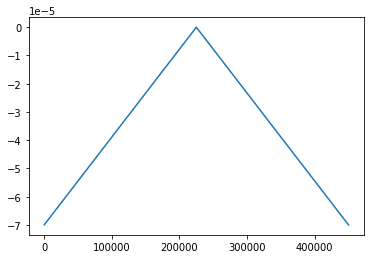

In [6]:
lens = Lens.Lens(
    diameter=4500e-6,
    height=70e-6,
    exponent=1.0,
    medium=Lens.Medium(2.348)
)

print(lens)


profile = lens.generate_profile()

print(np.isclose(np.max(profile),0))

plt.plot(profile)
plt.show()

In [7]:



med = Lens.Medium(refractive_index=1.0)


water = Lens.Water()

print(med)
print(water)

Medium()
Water(refractive_index=1.33)


## Simulation

CENTRE_PX:  4
n_pixels_in_sim:  9  pixel_size:  0.00045
Prop Size:  9
 Lens (diameter: 0.0045, height: 7e-05, medium: 2.0
Medium()


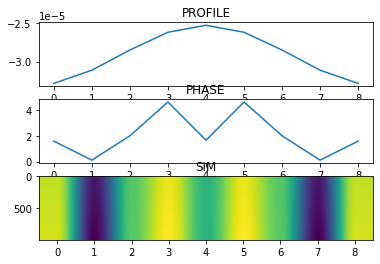

In [9]:
from lens_simulation import Lens, Simulation

import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack


A = 10000

from lens_simulation import Simulation


# n_pixels need to be consistent

sim_width = 4500e-6
pixel_size = 450e-6
# n_pixels = int(sim_width / pixel_size)

# # n_pixels must be odd (symmetry).
# if n_pixels % 2 == 0:
#     n_pixels += 1

# print(n_pixels)

lens = Lens.Lens(
    diameter=sim_width,
    height=70e-6,
    exponent=2.0,
    medium=Lens.Medium(2.348)
)
profile = lens.generate_profile(pixel_size)


# pixels size is defined by the sim
# define a simulation width (includes padding)
# TODO: minimum padding?
# escape path: 10%
# padding: 30%
# pad the sides of the profile to match the sim width

centre_px = (len(profile) - 1) // 2 
print("CENTRE_PX: ", centre_px)

medium = Lens.Medium(refractive_index=1.0)

print("n_pixels_in_sim: ", len(profile), " pixel_size: ", pixel_size)

freq_array = Simulation.generate_squared_frequency_array(n_pixels=len(profile), pixel_size=pixel_size)

delta = (lens.medium.refractive_index - medium.refractive_index) * profile
phase = (2 * np.pi * delta / medium.wavelength_medium ) % (2 * np.pi)

wavefront = A * np.exp(1j*phase)

# print("Wavefront shape: ", wavefront.shape)

wavefront = fftpack.fft(wavefront)

start_distance = 25e-3
finish_distance = 28e-3
n_slices = 1000
sim = np.ones(shape=(n_slices, len(profile)))
distances = np.linspace(start_distance, finish_distance, n_slices)
for i, z in enumerate(distances):
    
    prop = np.exp(1j * medium.wave_number * z)  * np.exp( (-1j * 2 * np.pi ** 2 * z * freq_array) / medium.wave_number)
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop * wavefront)

    output = np.sqrt(propagation.real**2 + propagation.imag**2)

    sim[i] = output

print("Prop Size: ", len(prop))

print(lens)
print(medium)

fig, ax = plt.subplots(3, 1)

ax[0].plot(profile)
ax[0].set_title("PROFILE")

ax[1].plot(phase)
ax[1].set_title("PHASE")

# print(sim.shape)
ax[2].set_title("SIM")
low, high = sim.shape[1] //2 - 1000, sim.shape[1] //2 + 1000 
# print(low, high)
ax[2].imshow(sim[:, low:high+1],  aspect="auto")
plt.show()





# David said it is ok to make everything 2D
# WHY skewed to the right?




